# Gas Stations in Mexico


![alt text](gas_station.jpg)

## Introduction

- Historically mexican population has been sensitive to fuel prices to the extent that it has even been a driver of political campaigns and discourse.
- Also, in recent times, customer service has become paramount in diverse areas related to the purchase of goods and services, 
- Finally, ourselves as fuel consumers, with the liberalization of prices from the energy reform, we wanted to see if added features influence consumption and ratings in Service Stations

We wanted to see if the data reflects our personal observations.

---

## Part 1 - Reading and preparing data

1. Import all the dependencies used in the project. 

In [1]:
import pandas as pd
import numpy as np
from numpy import NaN
import matplotlib.pyplot as plt
import requests
import json
import gmaps
from config import gkey

2. Define a function that will convert elements of a list into a single string that will be used later on the project.

In [2]:
def listToString(s):  
    
    # initialize an empty string 
    str1 = " " 
    
    # return string   
    return (str1.join(s)) 

3. Read data from two csv files and showing the first 5 rows to check how the data looks like

In [3]:
prices_file = "Resources/prices.csv"
places_file = "Resources/places.csv"
prices_df = pd.read_csv(prices_file)
places_df = pd.read_csv(places_file)

**Note:** The CSV files were originally XML files. Due to complexity of use with Python of that kind of file, we downloaded and converted both to CSV for better handling

In [4]:
prices_df.head()

,places,place,place_id,gas_price,type
0,NaN,NaN,11703.0,18.69,regular
1,NaN,NaN,NaN,19.69,premium
2,NaN,NaN,11702.0,18.19,regular
3,NaN,NaN,NaN,19.79,premium
4,NaN,NaN,NaN,18.25,diesel


In [5]:
prices_df.shape

(33215, 5)

In [6]:
places_df.head()

,name,cre_id,location/x,location/y,_place_id
0,"ESTACION DE SERVICIO CALAFIA, S.A. DE C.V.",PL/658/EXP/ES/2015,-116.92140,32.47641,2039
1,"DIGEPE, S.A. DE C.V. (07356)",PL/902/EXP/ES/2015,-99.74484,20.30370,2040
2,"DIAZ GAS, S.A. DE C.V.",PL/760/EXP/ES/2015,-106.45140,31.71947,2041
3,"COMBU-EXPRESS, S.A. DE C.V.",PL/825/EXP/ES/2015,-103.30420,20.71413,2042
4,"PETROMAX, S.A. DE C.V.",PL/585/EXP/ES/2015,-98.29977,26.03787,2043


In [7]:
places_df.shape

(12753, 5)

4. The prices_id base had to be managed, so we filled every "NaN" value of place_id with the corresponding ID from one cell above.

In [8]:
# Creating a column to replace NaNs with Places_ID
Place_ID = prices_df['place_id'].fillna(method='ffill')
# Adding Column to existing prices DataFrame
prices_df['Place_ID'] = Place_ID
# Eliminating original place_id from DataFrame
prices_df = prices_df.drop('place_id', axis = 1)
# Rearrange DataFrame
prices_df = prices_df[['Place_ID','gas_price','type']]
# Rename Place_ID
prices_df.columns = ['_place_id', 'gas_price','type']
prices_df.head()

,_place_id,gas_price,type
0,11703.0,18.69,regular
1,11703.0,19.69,premium
2,11702.0,18.19,regular
3,11702.0,19.79,premium
4,11702.0,18.25,diesel


5. Merging both DF into a single one by "_place_id" and renaming columns

In [9]:
Gas_Stations_df = pd.merge(places_df, prices_df, on="_place_id")
Gas_Stations_df = Gas_Stations_df.rename(columns={"_place_id":"place_id",
                                                 "location/x":"Lng",
                                                 "location/y":"Lat",
                                                 "type":"gas type"})
Gas_Stations_df


,name,cre_id,Lng,Lat,place_id,gas_price,gas type
0,"ESTACION DE SERVICIO CALAFIA, S.A. DE C.V.",PL/658/EXP/ES/2015,-116.92140,32.47641,2039,17.39,regular
1,"ESTACION DE SERVICIO CALAFIA, S.A. DE C.V.",PL/658/EXP/ES/2015,-116.92140,32.47641,2039,19.35,premium
2,"ESTACION DE SERVICIO CALAFIA, S.A. DE C.V.",PL/658/EXP/ES/2015,-116.92140,32.47641,2039,18.45,diesel
3,"DIGEPE, S.A. DE C.V. (07356)",PL/902/EXP/ES/2015,-99.74484,20.30370,2040,18.65,regular
4,"DIGEPE, S.A. DE C.V. (07356)",PL/902/EXP/ES/2015,-99.74484,20.30370,2040,18.99,premium
...,...,...,...,...,...,...,...
33210,GRUPO GASOLINERO DEL DIAMANTE HOLZ SA DE CV,PL/23508/EXP/ES/2020,-103.40990,22.83751,27300,18.59,premium
33211,GRUPO GASOLINERO DEL DIAMANTE HOLZ SA DE CV,PL/23508/EXP/ES/2020,-103.40990,22.83751,27300,18.89,diesel
33212,JAGREGAS 2 S.A. DE C.V.,PL/23510/EXP/ES/2020,-100.41290,20.67198,27304,16.99,regular
33213,JAGREGAS 2 S.A. DE C.V.,PL/23510/EXP/ES/2020,-100.41290,20.67198,27304,17.30,premium


## Part 2 - Setting up parameters and columns to use Google API

1. Creating a column for each new type of data we want to get.

In [10]:
Gas_Stations_df["Rating"] = ""
Gas_Stations_df["User Ratings"] ="" 
Gas_Stations_df["Google_Name"] = ""
Gas_Stations_df["Address"]= ""
Gas_Stations_df["Types"]= ""
Gas_Stations_df.head()

,name,cre_id,Lng,Lat,place_id,gas_price,gas type,Rating,User Ratings,Google_Name,Address,Types
0,"ESTACION DE SERVICIO CALAFIA, S.A. DE C.V.",PL/658/EXP/ES/2015,-116.92140,32.47641,2039,17.39,regular,,,,,
1,"ESTACION DE SERVICIO CALAFIA, S.A. DE C.V.",PL/658/EXP/ES/2015,-116.92140,32.47641,2039,19.35,premium,,,,,
2,"ESTACION DE SERVICIO CALAFIA, S.A. DE C.V.",PL/658/EXP/ES/2015,-116.92140,32.47641,2039,18.45,diesel,,,,,
3,"DIGEPE, S.A. DE C.V. (07356)",PL/902/EXP/ES/2015,-99.74484,20.30370,2040,18.65,regular,,,,,
4,"DIGEPE, S.A. DE C.V. (07356)",PL/902/EXP/ES/2015,-99.74484,20.30370,2040,18.99,premium,,,,,


2. Setting up the url and parameters for the API request

In [11]:
# URL
url_base = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

# Parameters
params = {
    "rankby":"distance",
    "type": "gas_station",
    "keyword": "fuel station",
    "key": gkey    
}

3. Because a 12,000+ calls had to be made to the API, we splitted up our database into five equal parts to use different api_keys

In [12]:
carlos_df = Gas_Stations_df.iloc[0:2491,:]
rodrigo_df = Gas_Stations_df.iloc[2491:4983,:]
pau_df = Gas_Stations_df.iloc[4983:7475,:]
eduardo_df = Gas_Stations_df.iloc[7475:9967,:]
sam_df =  Gas_Stations_df.iloc[9967:12460,:]

4. Initiating the loop to get the results for every Sub-DataFrame created

In [13]:
# We use iterrrows so we are able to get Latitude and Longitude from each row and insert both as one variable in params
for index, row in pau_df.iterrows():
    lat=row["Lat"]
    lon=row["Lng"]

    # We add the location as variable of the parameters, which is the most important one for our requests
    params["location"] = f"{lat},{lon}"
    
    active_df = carlos_df # Here we change the name of the DataFrame that was used for the loop
    
    # We use this print to check that every requests is executing
    print(f"Results for observation: {index}")
    
    # We try to store the values Rating, User Ratings, the name given by Google to that location and its address
    try:
        response = requests.get(url_base, params=params).json()
        active_df.loc[index, "Rating"] = response["results"][0]["rating"]
        active_df.loc[index, "User Ratings"] = response["results"][0]["user_ratings_total"]
        active_df.loc[index, "Google_Name"] = response["results"][0]["name"]
        active_df.loc[index, "Address"] = response["results"][0]["vicinity"]

    # We also inserted the types of establishment the gas station has, here is where we use the function defined on the top
        string = response["results"][0]["types"]
        string_value = listToString(string)
        string_value = string_value.replace(" ",", ")
    except (KeyError, IndexError):
        print("Missing field/result... skipping.")

# To storage the requests
        json_list.append(response)

IndentationError: unexpected unindent (<ipython-input-13-eb7a96487938>, line 26)

5. After obtaining all the data, we stored the 5 parts in different csv Files, read them and then concatenate them to get a final DataFrame

In [ ]:
carlos_df.head()

In [ ]:
carlos_df.to_csv("Resources/part1.csv")

In [14]:
# Reding all CSV
part1 = "Resources/part1.csv"
part2 = "Resources/part2.csv"
part3 = "Resources/part3.csv"
part4 = "Resources/part4.csv"
part5 = "Resources/part5.csv"
part1_df = pd.read_csv(part1)
part2_df = pd.read_csv(part2)
part3_df = pd.read_csv(part3)
part4_df = pd.read_csv(part4)
part5_df = pd.read_csv(part5)

In [15]:
# Gathering all the Frames into a list and doing the concat method
Frames = [part1_df,part2_df,part3_df,part4_df,part5_df]
Mexico_Gas_Stations = pd.concat(Frames)
# Resetting index
Mexico_Gas_Stations = Mexico_Gas_Stations.reset_index(drop=True)
# Dropping the first two columns that were not valuable
Mexico_Gas_Stations = Mexico_Gas_Stations.drop(columns=["Unnamed: 0","index"])
Mexico_Gas_Stations.head()


,name,cre_id,Lng,Lat,place_id,gas_price,gas type,Rating,User Ratings,Google_Name,Address,Types
0,"ESTACION DE SERVICIO CALAFIA, S.A. DE C.V.",PL/658/EXP/ES/2015,-116.92140,32.47641,2039,17.39,regular,4.3,3.0,Gasolinera Pemex,"Av de los Insurgentes No. 1910, Libramiento, T...","gas_station, point_of_interest, establishment"
1,"DIGEPE, S.A. DE C.V. (07356)",PL/902/EXP/ES/2015,-99.74484,20.30370,2040,18.65,regular,3.9,13.0,Pemex,"Carrt. Pachuca-Queretaro Km 58+500, Huichapan","gas_station, point_of_interest, establishment"
2,"DIAZ GAS, S.A. DE C.V.",PL/760/EXP/ES/2015,-106.45140,31.71947,2041,12.82,regular,4.3,261.0,TotalGas,"Av. López Mateos 1604, La Plata, Cd Juárez","gas_station, point_of_interest, establishment"
3,"COMBU-EXPRESS, S.A. DE C.V.",PL/825/EXP/ES/2015,-103.30420,20.71413,2042,18.64,regular,4.0,105.0,Gasolinera Pemex,"Perif. Nte. Ricardo Flores Magón Ote. No. 950,...","gas_station, point_of_interest, establishment"
4,"PETROMAX, S.A. DE C.V.",PL/585/EXP/ES/2015,-98.29977,26.03787,2043,14.79,regular,4.0,10.0,Petromax,"Río Purificación 800, Luis Donaldo Colosio Mur...","gas_station, point_of_interest, establishment"


In [16]:
Mexico_Gas_Stations.shape

(12460, 12)

## Part 3 - Using new DataFrame with data from API, cleaning and plotting

1. Saving all missing values in a different DataFrame and then removing them from the original one

In [17]:
missing_df = Mexico_Gas_Stations[Mexico_Gas_Stations['Rating'].isna()]
missing_df.shape

(24, 12)

In [18]:
Mexico_Gas_Stations = Mexico_Gas_Stations.dropna()
Mexico_Gas_Stations.shape

(12436, 12)

2. Checking if there are any duplicated values and dropping them from the original DF 

In [19]:
# identifying 
duplicated_station = Mexico_Gas_Stations.loc[Mexico_Gas_Stations[["name","Lat","Lng"]].duplicated(),"name"]
duplicated_station

12197    ADMINISTRADORA DEL COLORADO S. DE R.L. DE C.V.
Name: name, dtype: object

In [20]:
Mexico_Gas_Stations = Mexico_Gas_Stations.drop_duplicates(subset=["name","Lat","Lng"])
Mexico_Gas_Stations.shape

(12435, 12)

3. Inserting first plot to check how many gas stations offer Regular, Premium and Diesel products.

In [21]:
# Creating subset to have data counted by gas type
gas_type_df = Mexico_Gas_Stations.groupby(Mexico_Gas_Stations["gas type"]).count()["place_id"].to_frame()
gas_type_df

,place_id
gas type,
diesel,821
premium,753
regular,10861


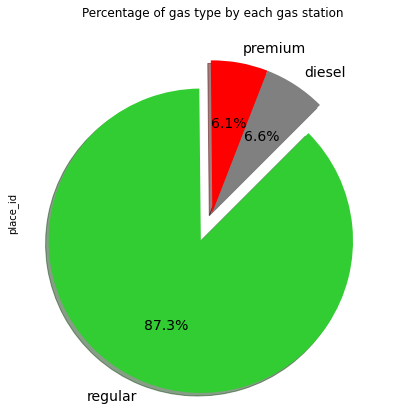

In [22]:
# Defining parameters
plt.figure(figsize=(15,15))
colors = ["grey", "red", "limegreen"]
axes = plt.subplot(122, aspect="equal")
explode = (0,0,0.2)

# Creating plot
gas_type_df.plot(kind="pie",explode=explode, autopct="%1.1f%%", colors=colors, ax=axes, y = "place_id", 
                     startangle=45, shadow=True, legend = False,fontsize=14)
plt.title("Percentage of gas type by each gas station")
plt.show()

4. Creating subsets for each gas type to show 2 different Histograms

In [23]:
diesel = Mexico_Gas_Stations.loc[Mexico_Gas_Stations["gas type"]=="diesel"]
premium = Mexico_Gas_Stations.loc[Mexico_Gas_Stations["gas type"]=="premium"]
regular = Mexico_Gas_Stations.loc[Mexico_Gas_Stations["gas type"]=="regular"]
diesel.mean() # Price mean $19.19
premium.mean() # Price mean $19.02
regular.mean() # Price mean $18.28

Lng             -100.972077
Lat               22.238439
place_id        9737.540742
gas_price         18.288123
Rating             3.297265
User Ratings      55.330080
dtype: float64

5. Creating overlapped histogram to compare the behaviour of the prices between the three gas types

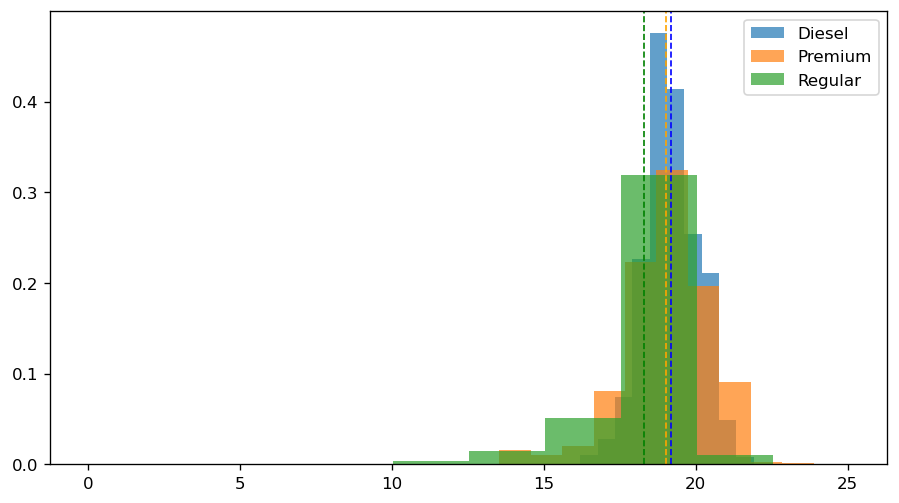

In [24]:
plt.figure(figsize=(9, 5), dpi=120)
plt.hist(diesel["gas_price"], 10, density=True, alpha=0.7, label="Diesel")
plt.hist(premium["gas_price"], 10, density=True, alpha=0.7, label="Premium")
plt.hist(regular["gas_price"], 10, density=True, alpha=0.7, label="Regular")
plt.axvline(diesel["gas_price"].mean(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(premium["gas_price"].mean(), color='orange', linestyle='dashed', linewidth=1)
plt.axvline(regular["gas_price"].mean(), color='green', linestyle='dashed', linewidth=1)
plt.legend()  
plt.show()

6. Creating 3 histograms to compare the behaviour of the ratings between the three gas types

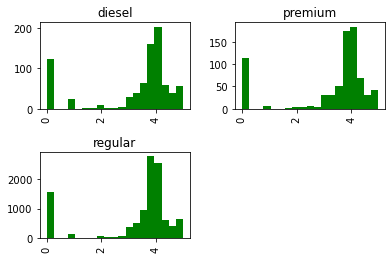

In [25]:
Mexico_Gas_Stations["Rating"].hist(by=Mexico_Gas_Stations["gas type"], bins=19, color="green")
plt.show()

6. Creating a boxplot from Ratings to check if there are any outliers

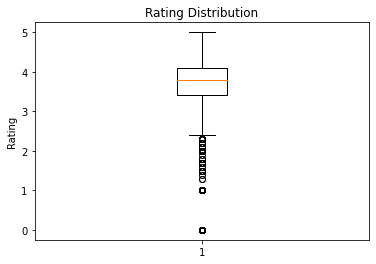

In [26]:
fig1, ax1 = plt.subplots()
ax1.set_title('Rating Distribution')
ax1.set_ylabel('Rating')
ax1.boxplot(Mexico_Gas_Stations["Rating"])
plt.show()

7. We decided to create a DF using cut, getting the mean of User Ratings and Gas Price by a Rating scale

In [27]:
# bins for Rating
np.percentile(Mexico_Gas_Stations["User Ratings"], np.arange(0,100, 20))
bins = [0,1,2,3,4,4.5,5]
names = ["<0.99", "1-1.99", "2-2.99", "3-3.99","4-4.49", "4.49-5.00"]
bins_rating = Mexico_Gas_Stations
bins_rating["Ratings"]=pd.cut(bins_rating["Rating"], bins, labels=names)
bins_rating= bins_rating.groupby(["Ratings"])
bins_rating= bins_rating[["Ratings", "User Ratings", "gas_price"]]
bins_rating = bins_rating.mean()
bins_rating

,User Ratings,gas_price
Ratings,,
<0.99,1.223404,18.406064
1-1.99,2.342342,18.418468
2-2.99,7.935484,18.381154
3-3.99,78.232859,18.416396
4-4.49,69.401521,18.317422
4.49-5.00,9.546012,18.484755


In [28]:
count_stations = Mexico_Gas_Stations
count_stations["Ratings"]=pd.cut(count_stations["Rating"], bins, labels=names)
count_stations= count_stations.groupby(["Ratings"])
count_stations= count_stations[["User Ratings"]]
count_stations = count_stations.count()
count_stations

,User Ratings
Ratings,
<0.99,188
1-1.99,111
2-2.99,589
3-3.99,6257
4-4.49,2498
4.49-5.00,978


# Note: Someone has to explain that there is no relation between the User Ratings and the prices

8. As we didn't find any significant relationship, we got the gas with the most User Ratings to check for any hint

In [29]:
# We use this code to show the whole string of the Types Column
pd.options.display.max_colwidth = 100

In [30]:
Mexico_Gas_Stations.loc[Mexico_Gas_Stations["User Ratings"]== Mexico_Gas_Stations["User Ratings"].max()].drop(columns="Ratings")["Types"]

2071    gas_station, restaurant, food, point_of_interest, store, establishment
Name: Types, dtype: object

8.1 We got the unique types from the gas types with Rating = 0

In [31]:
# As we found that the most rated gas has many location Types, we decided to get more info on this
Min_UserRating = Mexico_Gas_Stations.loc[Mexico_Gas_Stations["User Ratings"]==0]
Min_UserRating = Min_UserRating[["gas_price", "Rating","Types","Address", "User Ratings"]]
Min_UserRating

,gas_price,Rating,Types,Address,User Ratings
7,19.29,0.0,"gas_station, point_of_interest, establishment","Calle 15 590, Joyas de Anahuac, Cd Gral Escobedo",0.0
8,17.65,0.0,"gas_station, point_of_interest, establishment","Av Rayon 876, Secc Primera, Obrera, Ensenada",0.0
17,18.48,0.0,"gas_station, point_of_interest, establishment","Carret. Internacional Km 1170, San Cristóbal de las Casas",0.0
24,18.65,0.0,"gas_station, point_of_interest, establishment","Pedregal de Santo Domingo, San Nicolás de los Garza",0.0
27,17.55,0.0,"gas_station, point_of_interest, establishment","Blvd. Cuauhtemoc Sur 3658, Chulavista, Tijuana",0.0
...,...,...,...,...,...
12422,19.59,0.0,"gas_station, point_of_interest, establishment","Las Reynas, Irapuato",0.0
12424,19.09,0.0,"gas_station, point_of_interest, establishment","A Guanajuato No. 103, Zona Centro, Juventino Rosas",0.0
12425,17.70,0.0,"gas_station, point_of_interest, establishment","Carr. Acambaro - Jerecuaro, Km. 1, s/n, Centro, Acámbaro",0.0
12433,19.29,0.0,"gas_station, point_of_interest, establishment","Calle Postes 114, José María Pino Suárez, Ciudad de México",0.0


In [32]:
Min_UserRating["Types"].unique()

array(['gas_station, point_of_interest, establishment',
       'gas_station, convenience_store, cafe, food, point_of_interest, store, establishment',
       'gas_station, atm, convenience_store, finance, food, point_of_interest, store, establishment',
       'gas_station, convenience_store, food, point_of_interest, store, establishment',
       'gas_station, convenience_store, car_repair, food, point_of_interest, store, establishment',
       'gas_station, atm, finance, cafe, food, point_of_interest, establishment'],
      dtype=object)

8.2 Then, we did the same for the Gas Stations who have greater User Ratings than the mean value

# Discuss method of getting the top Gas Stations

In [33]:
Max_UserRating = Mexico_Gas_Stations.loc[(Mexico_Gas_Stations["User Ratings"]>=Mexico_Gas_Stations["User Ratings"].mean()) & (Mexico_Gas_Stations["User Ratings"]<=Mexico_Gas_Stations["User Ratings"].max())]
Max_UserRating = Max_UserRating[["gas_price", "Rating","Types","Address", "User Ratings"]]
Max_UserRating.head()

,gas_price,Rating,Types,Address,User Ratings
2,12.82,4.3,"gas_station, point_of_interest, establishment","Av. López Mateos 1604, La Plata, Cd Juárez",261.0
3,18.64,4.0,"gas_station, point_of_interest, establishment","Perif. Nte. Ricardo Flores Magón Ote. No. 950, Huentitán El Alto, Guadalajara",105.0
6,19.99,3.9,"gas_station, point_of_interest, establishment",Libramiento Ote. y,70.0
9,17.39,4.1,"gas_station, point_of_interest, establishment","Carrt. Libre Tijuana a Ensenada # 3109, Rosarito",61.0
16,18.09,4.3,"gas_station, point_of_interest, establishment","Av. Benito Juárez 1601, La Fuente, Guadalupe",57.0


In [34]:
Max_UserRating["Types"].unique()

array(['gas_station, point_of_interest, establishment',
       'gas_station, convenience_store, cafe, food, point_of_interest, store, establishment',
       'gas_station, point_of_interest, store, establishment',
       'gas_station, atm, finance, cafe, food, point_of_interest, establishment',
       'gas_station, car_wash, point_of_interest, establishment',
       'gas_station, atm, convenience_store, finance, food, point_of_interest, store, establishment',
       'gas_station, convenience_store, food, point_of_interest, store, establishment',
       'gas_station, atm, convenience_store, finance, restaurant, food, point_of_interest, store, establishment',
       'gas_station, restaurant, food, point_of_interest, store, establishment',
       'gas_station, car_repair, point_of_interest, establishment',
       'gas_station, atm, finance, point_of_interest, establishment',
       'gas_station, convenience_store, restaurant, food, point_of_interest, store, establishment',
       'gas_stat

# Someone has to explain that it is very clear that the most Gas Stations rated have more kinds of services on their locations, showing only a visual relationship

In [35]:
unique_types = Max_UserRating.groupby(Max_UserRating["Types"]).count()["Address"].to_frame()
unique_types


,Address
Types,
"gas_station, atm, convenience_store, finance, food, point_of_interest, store, establishment",6
"gas_station, atm, convenience_store, finance, restaurant, food, point_of_interest, store, establishment",1
"gas_station, atm, finance, cafe, food, point_of_interest, establishment",36
"gas_station, atm, finance, point_of_interest, establishment",2
"gas_station, car_repair, point_of_interest, establishment",2
"gas_station, car_wash, point_of_interest, establishment",2
"gas_station, convenience_store, cafe, food, point_of_interest, store, establishment",35
"gas_station, convenience_store, food, point_of_interest, store, establishment",9
"gas_station, convenience_store, grocery_or_supermarket, food, point_of_interest, store, establishment",1


# Explain also that it is very clear that we cannot conduct a statistical analyisis because more than 90% of stations have the "standard" type

9. We wanted to check if there was any specific geographic distribution of the gas stations with a scatter plot

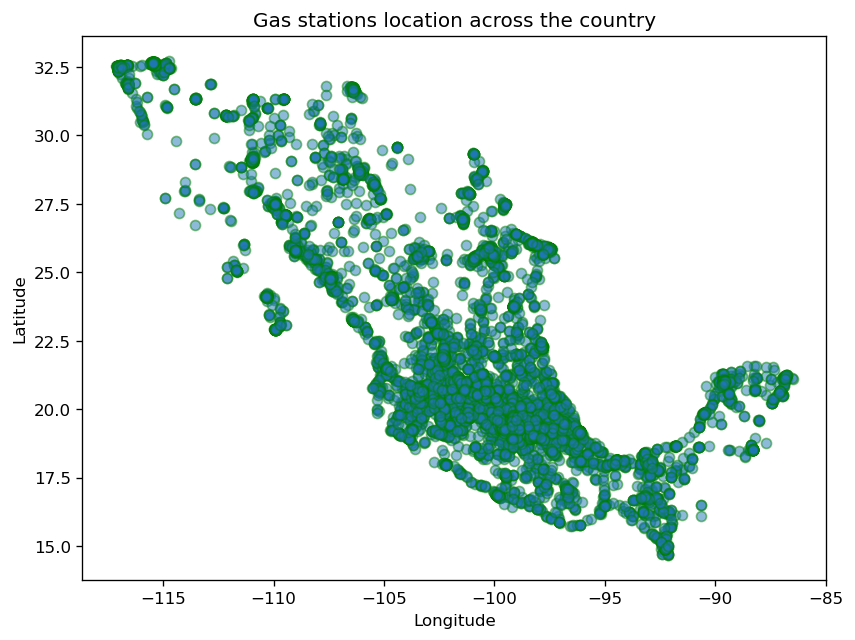

In [71]:
scatter_df = Mexico_Gas_Stations.loc[Mexico_Gas_Stations["Lng"]<=50]
plt.figure(figsize=(8, 6), dpi=120)
plt.scatter(scatter_df["Lng"],scatter_df["Lat"], edgecolor="green", alpha=0.5)
plt.title("Gas stations location across the country")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

10. We decided to do the same only for the best ratings (4 and above)

In [37]:
top_stations_df = Mexico_Gas_Stations.loc[Mexico_Gas_Stations["Rating"] >= 4]
top_stations_df = top_stations_df.loc[top_stations_df["Lng"]<=50]

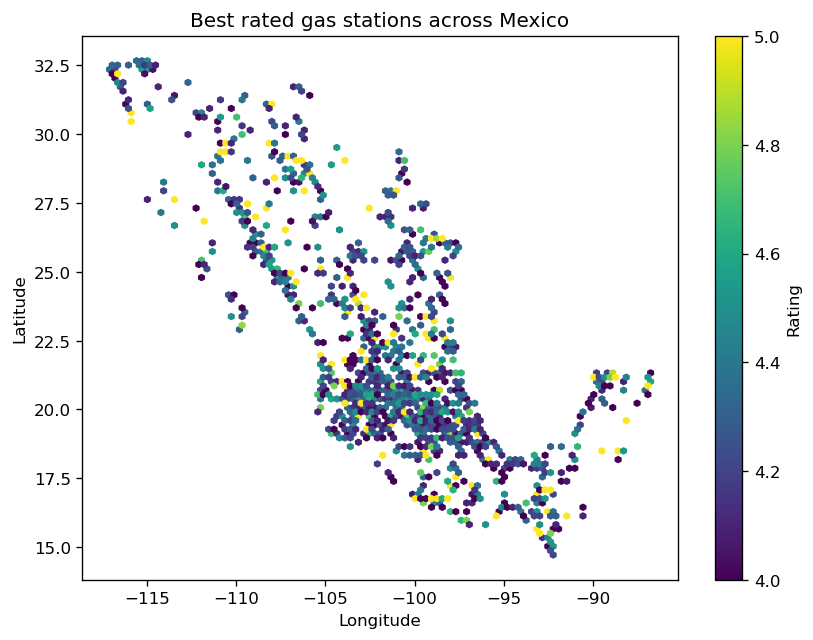

In [70]:
plt.figure(figsize=(8, 6), dpi=120)
plt.hexbin(top_stations_df["Lng"],top_stations_df["Lat"], C=top_stations_df["Rating"])
cb=plt.colorbar()
cb.set_label("Rating")
plt.title("Best rated gas stations across Mexico")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## Part 4 - Heat Maps

1. We got the heat map of the gas stations in Mexico for 3 different categories:
---
### Top 100 best rating

In [42]:
best_rating_df = Mexico_Gas_Stations.sort_values(by="Rating",ascending=False)
best_rating_df = best_rating_df.sort_values(by="User Ratings",ascending=False).head(100)
best_rating_df.head()

,name,cre_id,Lng,Lat,place_id,gas_price,gas type,Rating,User Ratings,Google_Name,Address,Types,Ratings
2071,ESTACIÓN DE SERVICIOS POMAS SA DE CV,PL/2315/EXP/ES/2015,-103.30660,24.12847,4143,18.79,regular,4.4,2374.0,Truck Stop 001,"Km. 105.8, México 49, Juan Aldama","gas_station, restaurant, food, point_of_interest, store, establishment",4-4.49
468,PARADERO STA MARIA S.A. DE C.V.,PL/817/EXP/ES/2015,-101.40970,26.75702,2507,18.48,regular,4.5,2078.0,Estación Monky's,"Carretera Federal 57 2502 COAH Estados Unidos Mexicanos, México 57 2502","gas_station, point_of_interest, establishment",4-4.49
2531,"BP ESTACIONES Y SERVICIOS ENERGETICOS, S.A. DE C.V.",PL/5400/EXP/ES/2015,-99.23764,19.49989,4705,19.09,regular,4.3,2014.0,bp,"Perif. Blvd. Manuel Ávila Camacho, Cd. Satélite, Naucalpan de Juárez","gas_station, convenience_store, cafe, food, point_of_interest, store, establishment",4-4.49
1162,"BP ESTACIONES Y SERVICIOS ENERGETICOS, S.A. DE C.V.",PL/1553/EXP/ES/2015,-99.12736,19.33902,3217,19.49,regular,4.2,2012.0,bp,"Calz Taxqueña, Paseos de Taxqueña, Ciudad de México","gas_station, convenience_store, food, point_of_interest, store, establishment",4-4.49
79,"GRUPO OCTANO, S.A. DE C.V.",PL/497/EXP/ES/2015,-100.79240,19.90187,2118,19.48,regular,3.8,1804.0,Pemex,"México 15D, Zinapecuaro de Figueroa","gas_station, point_of_interest, establishment",3-3.99


In [48]:
#Set api key
gmaps.configure(api_key=gkey)
#Set lat and lng as locations
locations = best_rating_df[["Lat","Lng"]]
#Set gas_price as weight
weight=best_rating_df["Rating"]

In [49]:
# Plot Best Rating Heatmap
fig = gmaps.figure()
max_intensity = np.max(weight)

# Create heat layer
heatmap = gmaps.heatmap_layer(
    locations, 
    weights = weight, 
    dissipating=False, 
    point_radius=.2)

# Add layer
fig.add_layer(heatmap)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

* Aditionally, we added a marker layer for the best rated just to give some extra information about the best gas stations

In [69]:
info_box_template = """
<dl>
<dt>Name</dt><dd>{name}</dd>
<dt>City</dt><dd>{Address}</dd>
<dt>Rating</dt><dd>{Rating}</dd>
</dl>
"""
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
gas_info = [info_box_template.format(**row) for index, row in best_rating_df.iterrows()]
locations = best_rating_df[["Lat", "Lng"]]
# Add marker layer ontop of heat map
markers = gmaps.marker_layer(locations, info_box_content = gas_info)
markers
# Display Map
fig.add_layer(markers)

fig

Figure(layout=FigureLayout(height='420px'))

### Top 100 minimum prices

In [56]:
# Removing 0 User Ratings because they don't mean anything to the study
lowest_price_df = Mexico_Gas_Stations.loc[Mexico_Gas_Stations["User Ratings"]>0]
# Using only prices above 16.45 that correspond to the minimum price value reported at the end of 2017
lowest_price_df = lowest_price_df.loc[lowest_price_df["gas_price"]>16.45]
lowest_price_df = lowest_price_df.sort_values(by="Rating",ascending=False)
lowest_price_df = lowest_price_df.sort_values(by="User Ratings",ascending=False)
lowest_price_df = lowest_price_df.sort_values(by="gas_price",ascending=True).head(100)
lowest_price_df.head()

,name,cre_id,Lng,Lat,place_id,gas_price,gas type,Rating,User Ratings,Google_Name,Address,Types,Ratings
8956,SERVICIO BOCA SA DE CV,PL/3045/EXP/ES/2015,-96.16934,19.21568,11164,16.47,regular,4.3,134.0,PeMex,"Cerca de Tecnológico, Veracruz","gas_station, point_of_interest, establishment",4-4.49
9785,ISIGAS GUADALUPE SA DE CV,PL/10931/EXP/ES/2015,-100.17060,25.66982,13061,16.48,premium,3.0,2.0,Gasolinera Pemex,"Av Maestro Israel Cavazos Garza 125, Cerro Azul, Guadalupe","gas_station, point_of_interest, establishment",2-2.99
2461,NOVOGAS TOLLOCAN SA DE CV,PL/5933/EXP/ES/2015,-96.13433,19.19525,4635,16.48,regular,4.1,72.0,Pemex,"Av. Gral. Prim 132, Centro, Veracruz","gas_station, point_of_interest, establishment",4-4.49
5343,"Gasolinera Olympia de Veracruz, S.A. de C.V.",PL/6783/EXP/ES/2015,-96.13139,19.18961,7525,16.48,regular,3.8,111.0,Gasolinera Olympia de Veracruz,"Av. Gral. Prim 244-246, Ricardo Flores Magón, Veracruz","gas_station, point_of_interest, establishment",3-3.99
4083,Grupo Garcia Montaño SA de CV,PL/4196/EXP/ES/2015,-115.47870,32.65646,6262,16.49,regular,3.8,56.0,Pemex,"Bl, Boulevard Adolfo López Mateos N 820, Bella Vista, Mexicali","gas_station, point_of_interest, establishment",3-3.99


In [57]:
#Set api key
gmaps.configure(api_key=gkey)
#Set lat and lng as locations
locations = lowest_price_df[["Lat","Lng"]]
#Set Humidity as weight
weight=lowest_price_df["gas_price"]
# #Plot Heatmap
# fig = gmaps.figure
# max_intensity = np.max(weight)

In [58]:
# Plot Heatmap
fig = gmaps.figure()
max_intensity = np.max(weight)

# Create heat layer
heatmap = gmaps.heatmap_layer(
    locations, 
    weights = weight, 
    dissipating=False, 
    max_intensity=17, 
    point_radius=.2)

# Add layer
fig.add_layer(heatmap)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

### Top 100 worst rated

In [65]:
worst_rating_df = Mexico_Gas_Stations.sort_values(by="Rating",ascending=True) 
worst_rating_df = worst_rating_df.loc[worst_rating_df["User Ratings"]>worst_rating_df["User Ratings"].mean()]
worst_rating_df = worst_rating_df.sort_values(by="Rating",ascending=True).head(100)
worst_rating_df.head()

,name,cre_id,Lng,Lat,place_id,gas_price,gas type,Rating,User Ratings,Google_Name,Address,Types,Ratings
1883,ESTACIÓN DE SERVICIO LOS AVALLANOS S.A. DE C.V.,PL/2437/EXP/ES/2015,-86.85023,21.03732,3938,19.89,regular,2.5,476.0,Pemex,"Reserva Territorial ""Sascaberas"", Mz 11 Lote 01 299, Supermanzana","gas_station, point_of_interest, establishment",2-2.99
6010,"OPERADORA DE ESTACIONES DE SERVICIO 20-20, S.A. DE C.V.",PL/6711/EXP/ES/2015,-109.70940,23.15160,8193,19.84,regular,2.7,130.0,Pemex,"La Paz-San José del Cabo Mz 3-C LT L-2, Las Veredas","gas_station, point_of_interest, establishment",2-2.99
1124,INMOBILIARIA OSTUNI S.A. DE C.V.,PL/2040/EXP/ES/2015,-86.93461,20.49878,3179,19.84,regular,2.8,150.0,Pemex,"Av Lic Benito Juárez 73, Emiliano Zapata, San Miguel de Cozumel","gas_station, point_of_interest, establishment",2-2.99
572,SERVICIOS PLAYACAR S.A. DE C.V.,PL/1482/EXP/ES/2015,-87.07149,20.64288,2625,19.99,regular,2.8,106.0,PEMEX,"Carr. Cancún - Tulum manzana 51, Luis Donaldo Colosio, Playa del Carmen","gas_station, point_of_interest, establishment",2-2.99
4587,"Estación de Servicios Palmas Cancún, S.A. de C.V.",PL/4031/EXP/ES/2015,-86.84990,21.04280,6769,19.69,regular,2.8,81.0,Gasolinera Pemex,"Lote 6-01,6-02 Y 6-03 Carretera Cancun, Puerto Juárez Km.17, Rancho Santa Ana","gas_station, point_of_interest, establishment",2-2.99


In [67]:
#Set api key
gmaps.configure(api_key=gkey)
#Set lat and lng as locations
locations = worst_rating_df[["Lat","Lng"]]
#Set gas_price as weight
weight=worst_rating_df["Rating"]

In [68]:
# Plot Best Rating Heatmap
fig = gmaps.figure()
max_intensity = np.max(weight)

# Create heat layer
heatmap = gmaps.heatmap_layer(
    locations, 
    weights = weight, 
    dissipating=False, 
    point_radius=.2)

# Add layer
fig.add_layer(heatmap)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

## Part 5 - Conclusions